In [117]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.regularizers import l2


from sklearn.metrics import accuracy_score

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
dateset=pd.read_csv('drive/MyDrive/kaggle/icml_face_data.csv')

In [120]:
dateset

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [121]:
cols=[]
for col in dateset.columns:
    cols.append(col.strip())
dateset.columns = cols

In [122]:
dateset.columns

Index(['emotion', 'Usage', 'pixels'], dtype='object')

In [123]:
trian = dateset.loc[dateset['Usage'] == 'Training',:].reset_index(drop=True)
trian.drop('Usage',axis=1,inplace=True)
test = dateset.loc[dateset['Usage'] != 'Training'].reset_index(drop=True)
test.drop('Usage',axis=1,inplace=True)

In [124]:
def emot(number):
    mapping={0:'Angry',
             1:'Disgust',
             2:'Fear',
             3:'Happy',
             4:'Sad',
             5:'Surprise',
             6:'Neutral'}
    return mapping[number]

def pixel_to_img(number):
    vec = trian.loc[number,'pixels']
    emo = trian.loc[number,'emotion']
    vec=np.array(vec.split()).astype(int).reshape(48,48)
    return vec,emo

def draw_im(vec,emo):
    plt.figure(figsize=(4,4))
    plt.imshow(vec,cmap="gray")
    plt.title(emot(emo))
    plt.show()

In [125]:
def split_XY(df):
    X=[]
    Y=[]
    for i in tqdm(range(len(df))):
        X.append(pixel_to_img(i)[0].reshape(48,48,1))
        Y.append(pixel_to_img(i)[1])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

train_x,train_y=split_XY(trian)
vali_x,vali_y = split_XY(test)

100%|██████████| 7178/7178 [00:18<00:00, 380.35it/s]


In [126]:
train_x = train_x/255
vali_x = vali_x/255

In [127]:
CNN_model = tf.keras.Sequential([
    
    #48*48*1
    Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same',input_shape=(48,48,1)),
    Dropout(0.2),
    Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    
    #24*24*64
    Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    
    #12*12*128
    Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    
    #6*6*256
    Flatten(), #6*6*256
    
    Dense(units=256,activation='relu'),
    Dense(units=128,activation='relu'),
    Dense(units=64,activation='relu'),
    
    Dense(units=7,activation='softmax')

])
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 dropout_9 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 dropout_10 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 dropout_11 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 64)      

In [135]:
Batch_Size = 512
Num_of_Epoch = 80
Learning_Rate = 1e-3

# 最佳化器
Optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)

# 損失函數
Loss_Function = tf.keras.losses.SparseCategoricalCrossentropy()

# 編譯模型
CNN_model.compile(
    loss=Loss_Function, 
    optimizer=Optimizer_Adam, 
    metrics=['accuracy']
)

# 學習率排程器(Learning Rate Scheduler
def scheduler(epoch, lr):
  if epoch < 20:     
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [136]:
History = CNN_model.fit(
    x = train_x,
    y = train_y,
    validation_data = (vali_x, vali_y),
    batch_size = Batch_Size,
    epochs = Num_of_Epoch,
    callbacks=[callback]
)

Epoch 1/80
57/57 [==============================] - 13s 198ms/step - loss: 0.3957 - accuracy: 0.8564 - val_loss: 0.2359 - val_accuracy: 0.9437 - lr: 0.0010
Epoch 2/80
57/57 [==============================] - 11s 192ms/step - loss: 0.3794 - accuracy: 0.8601 - val_loss: 0.2427 - val_accuracy: 0.9345 - lr: 0.0010
Epoch 3/80
57/57 [==============================] - 11s 192ms/step - loss: 0.3533 - accuracy: 0.8715 - val_loss: 0.2252 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 4/80
57/57 [==============================] - 11s 192ms/step - loss: 0.3523 - accuracy: 0.8727 - val_loss: 0.2011 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/80
57/57 [==============================] - 11s 192ms/step - loss: 0.3536 - accuracy: 0.8739 - val_loss: 0.1861 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 6/80
57/57 [==============================] - 11s 192ms/step - loss: 0.3390 - accuracy: 0.8797 - val_loss: 0.1594 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 7/80
57/57 [==============================] - 11s 192ms/st

In [137]:
loss = History.history["loss"]
accuracy = History.history["accuracy"]
val_loss = History.history["val_loss"]
val_accuracy = History.history["val_accuracy"]

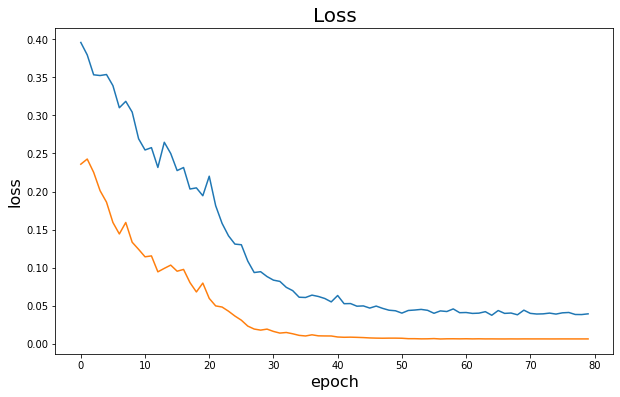

In [138]:
# loss
plt.figure(figsize=(10,6))
plt.plot(loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.title("Loss", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.show()

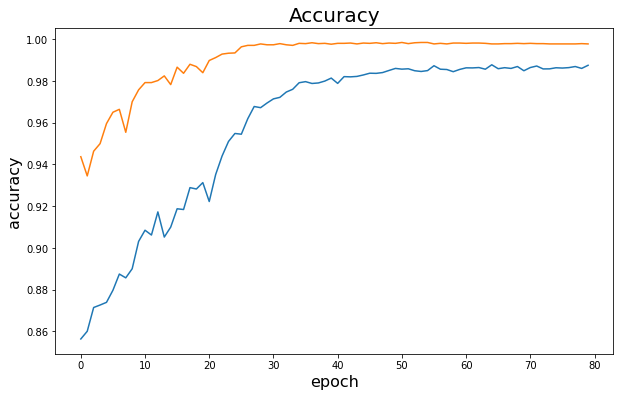

In [139]:
# accuracy
plt.figure(figsize=(10,6))
plt.plot(accuracy, label="train acc")
plt.plot(val_accuracy, label="val acc")
plt.title("Accuracy", fontsize=20)
plt.xlabel("epoch", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.show()

In [140]:
CNN_model.save('trained_model', save_format='tf')

INFO:tensorflow:Assets written to: trained_model/assets


INFO:tensorflow:Assets written to: trained_model/assets


In [141]:
!zip -r trained_model.zip trained_model/
!cp trained_model.zip drive/MyDrive/kaggle

updating: trained_model/ (stored 0%)
updating: trained_model/assets/ (stored 0%)
updating: trained_model/saved_model.pb (deflated 90%)
updating: trained_model/keras_metadata.pb (deflated 94%)
updating: trained_model/variables/ (stored 0%)
updating: trained_model/variables/variables.index (deflated 73%)
updating: trained_model/variables/variables.data-00000-of-00001 (deflated 33%)
